# Необходимые библиотеки

In [ ]:
from collections import Counter

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Чтение данных

In [ ]:
file_path = 'data.json'
data = pd.read_json(file_path)

In [ ]:
data.sample(n=5)

,id,cuisine,ingredients
21627,42012,french,"[large egg yolks, buttermilk, salt, flat leaf ..."
35229,12161,italian,"[ground black pepper, bacon, fresh parsley, bu..."
31555,1462,italian,"[rosemary sprigs, olive oil, black pepper, red..."
20551,31962,italian,"[lime, black olives, ground cumin, pinenuts, e..."
28661,22702,irish,"[baking soda, buttermilk, flour, pepper, butte..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


Необходимо удалить id, т.к. при обучении он не несет полезной информации.

Также удалим одинаковые рецепты

In [ ]:
data.drop('id', axis=1, inplace=True)

In [ ]:
data['ingredients_str'] = data['ingredients'].apply(lambda x: ' '.join(sorted(x)))

data.duplicated(subset=['cuisine', 'ingredients_str']).sum()

517

In [ ]:
data.drop_duplicates(subset=['cuisine', 'ingredients_str'], inplace=True)
data.drop('ingredients_str', axis=1, inplace=True)

In [ ]:
len(data)

39257

# Анализ данных

## Распределение кухонь

In [ ]:
cuisine_distribution = data['cuisine'].value_counts()
cuisine_distribution

italian         7758
mexican         6376
southern_us     4235
indian          2980
chinese         2644
french          2609
cajun_creole    1525
thai            1518
japanese        1387
greek           1162
spanish          977
korean           818
moroccan         810
vietnamese       806
british          796
filipino         750
irish            662
jamaican         510
russian          486
brazilian        448
Name: cuisine, dtype: int64

In [ ]:
cuisine_plot = cuisine_distribution[:10]
cuisine_plot['others'] = cuisine_distribution[10:].sum()
cuisine_plot

italian         7758
mexican         6376
southern_us     4235
indian          2980
chinese         2644
french          2609
cajun_creole    1525
thai            1518
japanese        1387
greek           1162
others          7063
Name: cuisine, dtype: int64

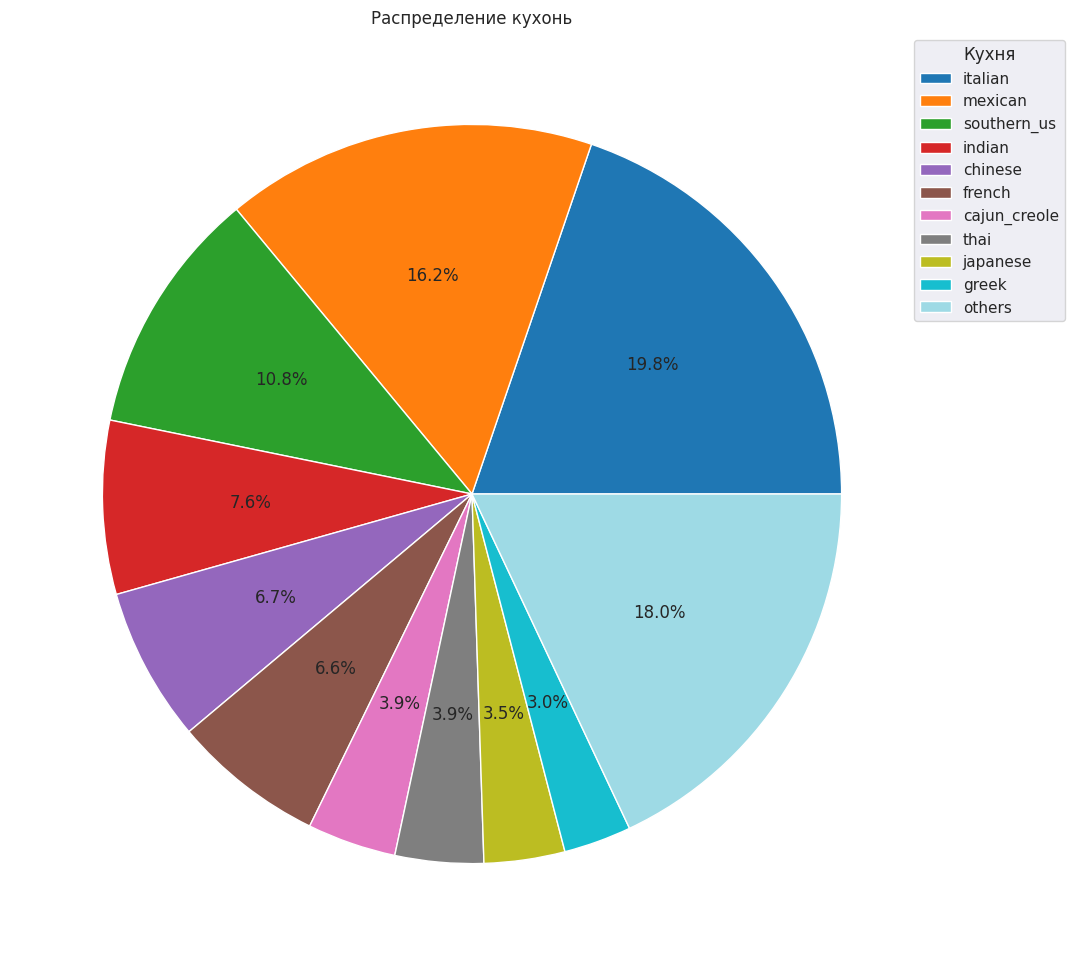

In [ ]:
labels = cuisine_plot.index

cuisine_plot.plot.pie(figsize=(12, 12),
                      title='Распределение кухонь',
                      autopct='%1.1f%%',
                      labels=None,
                      cmap='tab20')

plt.legend(title='Кухня', loc='upper right',
labels=labels, bbox_to_anchor=(1.15, 1))

plt.ylabel(None);

Распределение кухонь в обучающем наборе данных показывает, что некоторые кухни, такие как итальянская, мексиканская и кухня южных штатов США, представлены гораздо больше, чем другие, например, ямайская или русская.

Это может оказать влияние на производительность модели, особенно в отношении менее представленных кухонь.

## Количество ингридиентов в кухнях

In [ ]:
all_ingredients = sum(data['ingredients'], [])
unique_ingredients = set(all_ingredients)
total_unique_ingredients = len(unique_ingredients)

ingredients_per_cuisine = Counter()
for _, row in tqdm(data.iterrows()):
    ingredients_per_cuisine[row['cuisine']] += len(row['ingredients'])

average_ingredients_per_cuisine = {cuisine: total / cuisine_distribution[cuisine]
                                   for cuisine, total in ingredients_per_cuisine.items()}

average_ingredients_per_cuisine = dict(sorted(average_ingredients_per_cuisine.items(), key=lambda item: item[1]))

39257it [00:02, 16500.98it/s]


In [ ]:
total_unique_ingredients, average_ingredients_per_cuisine

(6714,
 {'irish': 9.326283987915408,
  'brazilian': 9.607142857142858,
  'southern_us': 9.647697756788666,
  'british': 9.733668341708542,
  'japanese': 9.788031723143476,
  'french': 9.852050594097355,
  'italian': 9.922531580304202,
  'filipino': 10.018666666666666,
  'greek': 10.185886402753873,
  'russian': 10.246913580246913,
  'spanish': 10.456499488229273,
  'mexican': 10.887860727728985,
  'korean': 11.28606356968215,
  'chinese': 11.973146747352496,
  'jamaican': 12.162745098039215,
  'thai': 12.543478260869565,
  'cajun_creole': 12.624918032786885,
  'vietnamese': 12.699751861042184,
  'indian': 12.719463087248322,
  'moroccan': 12.97283950617284})

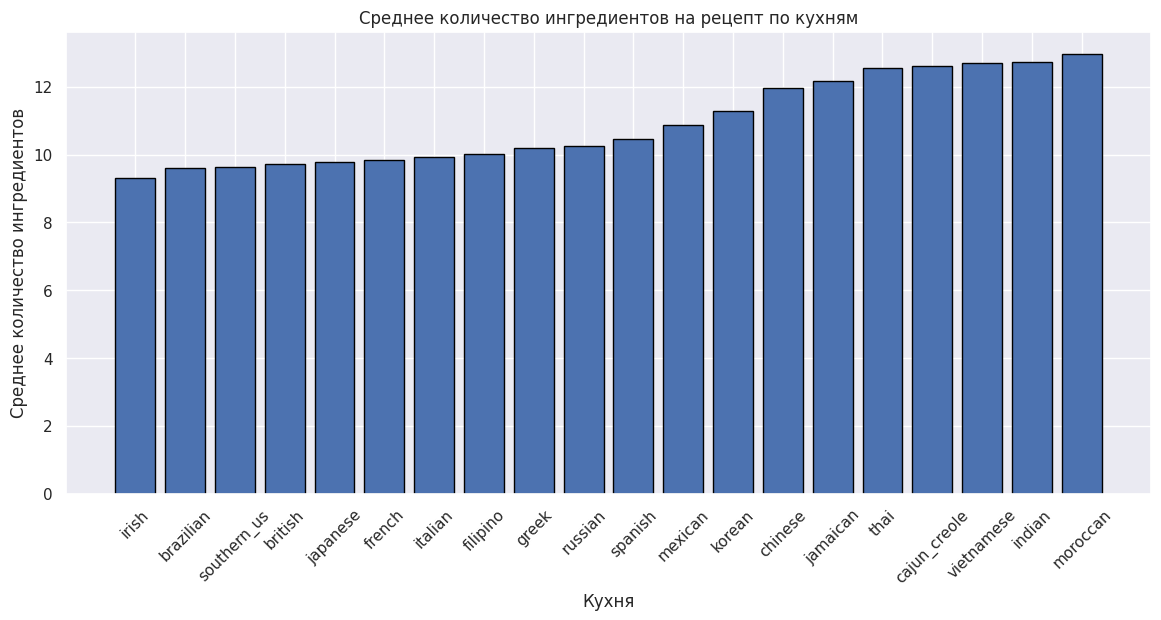

In [ ]:
plt.figure(figsize=(14, 6))
plt.bar(average_ingredients_per_cuisine.keys(),
        average_ingredients_per_cuisine.values(),
        edgecolor='black')
plt.title('Среднее количество ингредиентов на рецепт по кухням')
plt.xlabel('Кухня')
plt.ylabel('Среднее количество ингредиентов')
plt.xticks(rotation=45)
plt.show()

В датасете представлено 6714 уникальных ингредиентов.

Среднее количество ингредиентов на рецепт варьируется в зависимости от кухни. Например, ямайская кухня в среднем использует более 13 ингредиентов на рецепт, в то время как итальянская кухня использует около 9,8 ингредиента на рецепт.

Эти различия могут быть полезны для классификации кухонь.

Среднее количество ингредиентов на рецепт варьируется в зависимости от кухни. Например, ямайская кухня в среднем использует более 13 ингредиентов на рецепт, в то время как итальянская кухня использует около 9,8 ингредиента на рецепт. Эти различия могут быть полезны для классификации кухонь.

## Наиболее частые ингридиенты в кухнях

39257it [00:04, 9256.73it/s] 


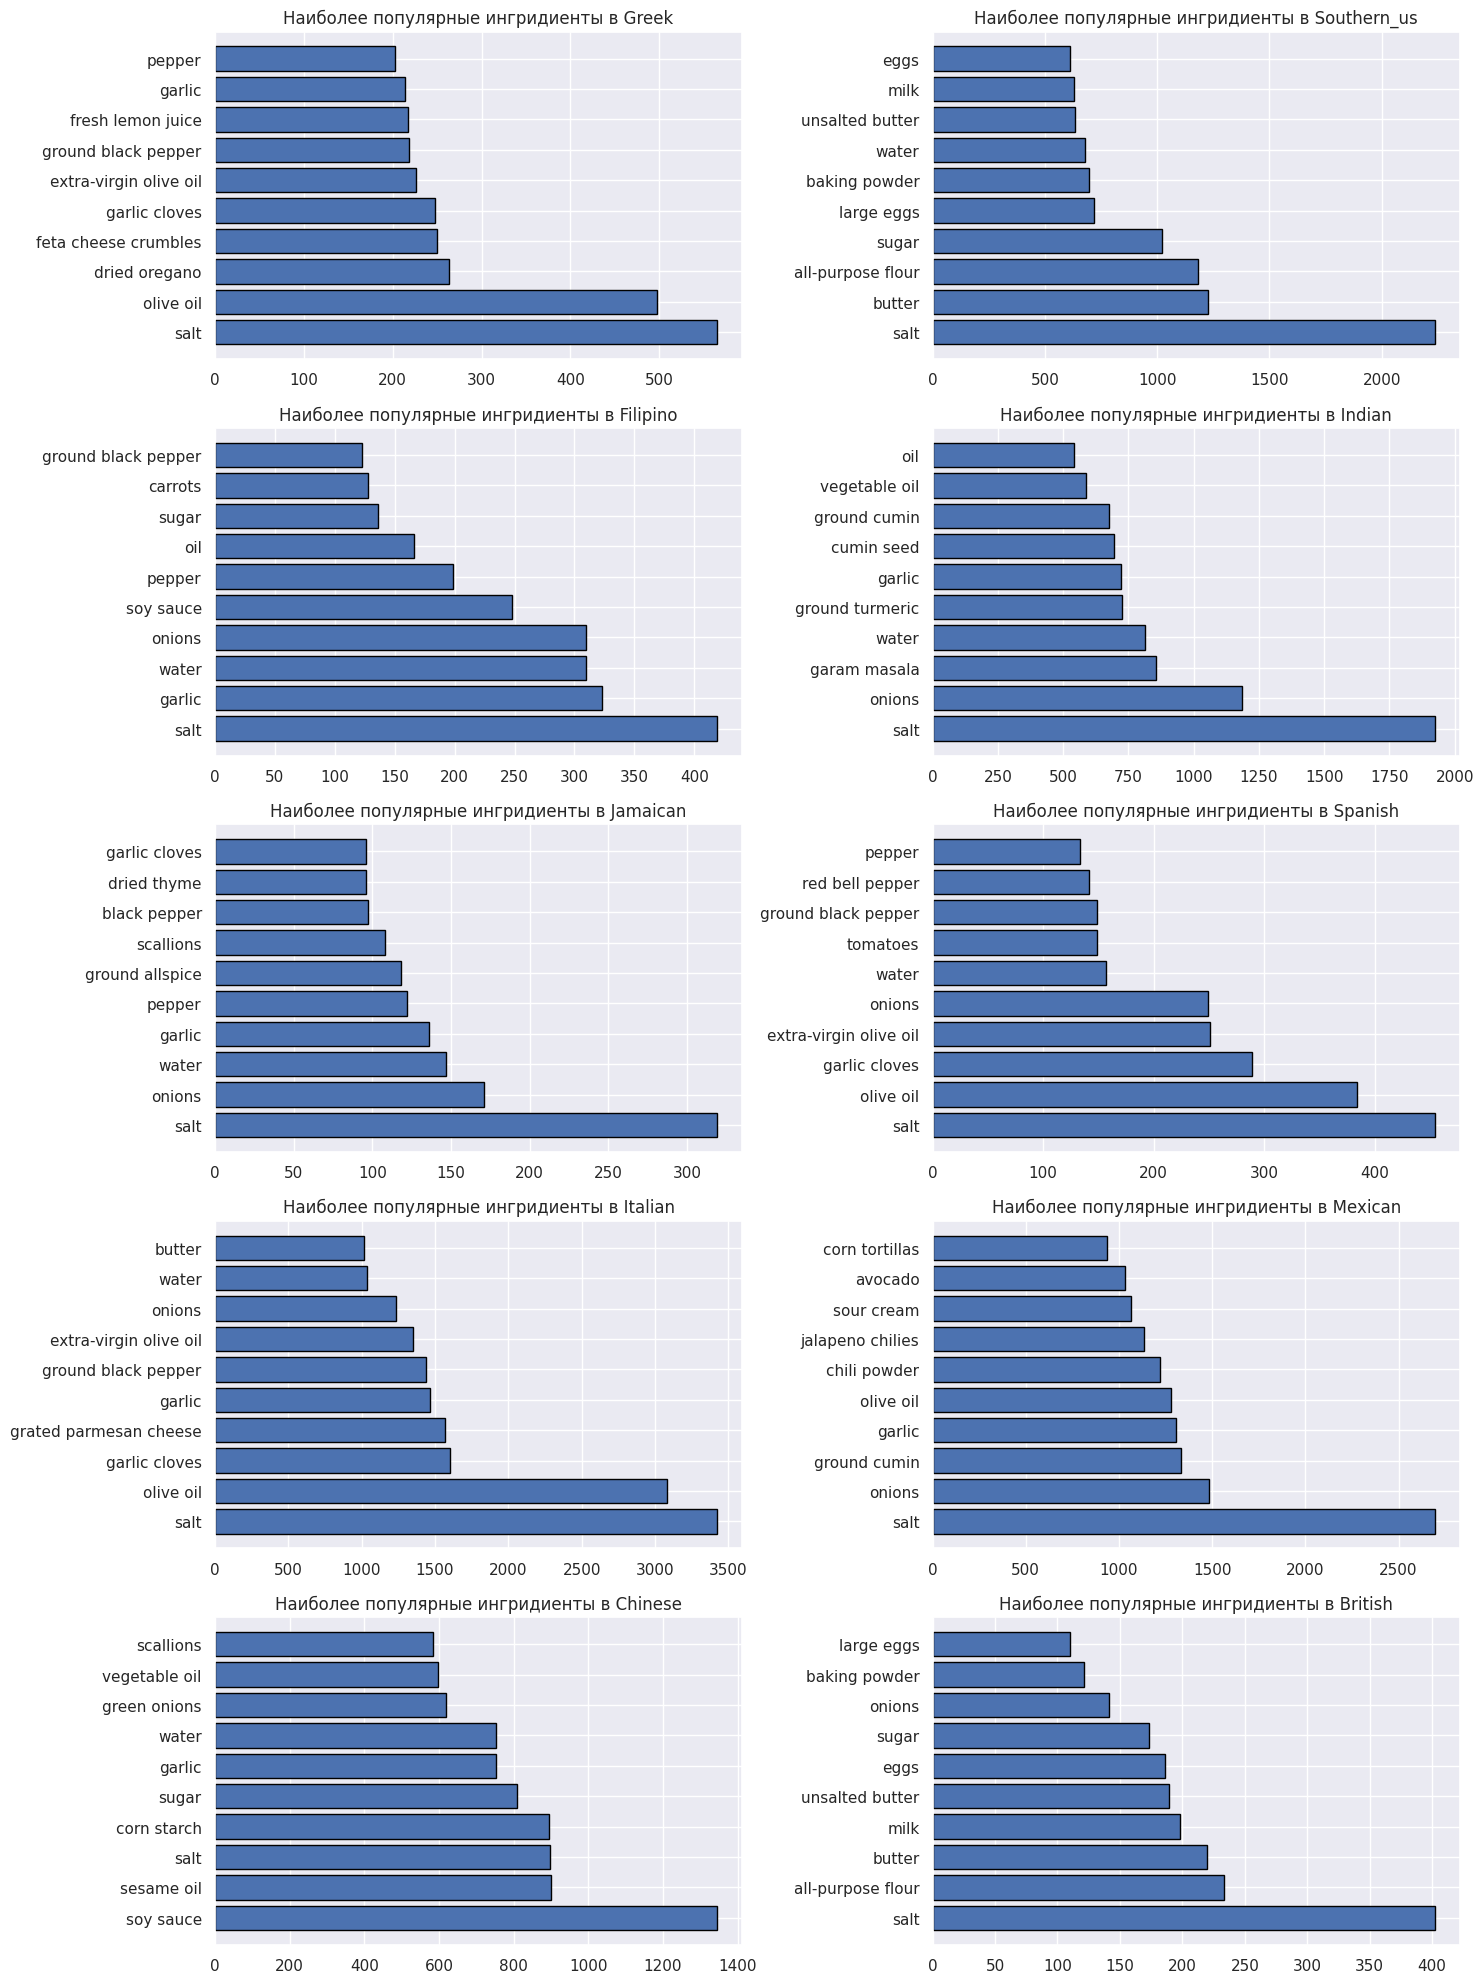

In [ ]:
# Агрегация ингредиентов для каждой кухни
ingredients_by_cuisine = {}
for _, row in tqdm(data.iterrows()):
    cuisine = row['cuisine']
    ingredients = row['ingredients']
    if cuisine not in ingredients_by_cuisine:
        ingredients_by_cuisine[cuisine] = Counter()
    ingredients_by_cuisine[cuisine].update(ingredients)

# Визуализация наиболее популярных ингредиентов для нескольких кухонь
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
cuisines_to_display = list(ingredients_by_cuisine.keys())[:10] # Отображение для первых четырех кухонь

for ax, cuisine in zip(axes.flatten(), cuisines_to_display):
    most_common_ingredients = ingredients_by_cuisine[cuisine].most_common(10)
    ingredients, counts = zip(*most_common_ingredients)
    ax.barh(ingredients, counts, edgecolor='black')
    ax.set_title(f'Наиболее популярные ингридиенты в {cuisine.capitalize()}')

plt.tight_layout()
plt.show()

## Количество ингридиентов в каждом рецепте

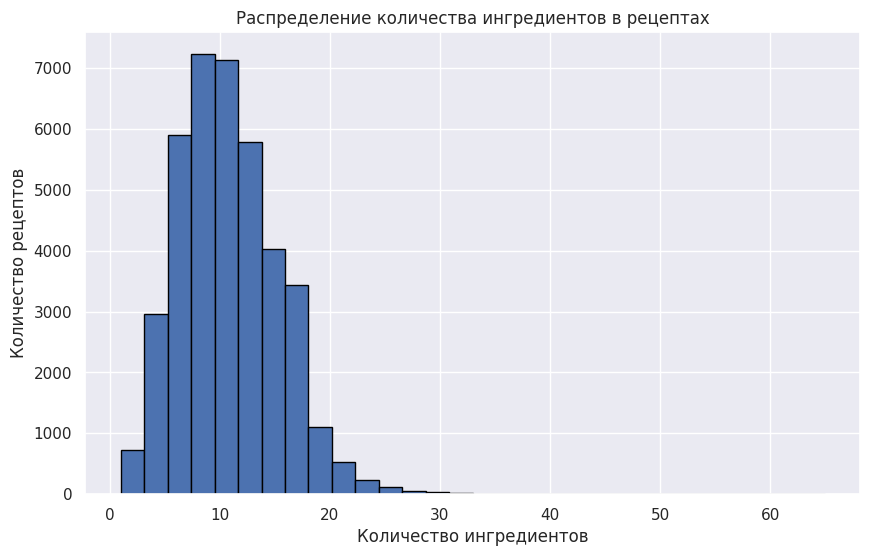

In [ ]:
data['count'] = data['ingredients'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(data['count'], bins=30, edgecolor='black')
plt.title('Распределение количества ингредиентов в рецептах')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Количество рецептов')
plt.show()

In [ ]:
data['count'].describe()

count    39257.000000
mean        10.783911
std          4.422210
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: count, dtype: float64

Распределение количества ингредиентов в рецептах показывает, что в среднем рецепт содержит около 10,8 ингредиентов.

Большинство рецептов имеют от 8 до 13 ингредиентов, но есть и такие, в которых используется всего 1 ингредиент или до 60 ингредиентов.

Это разнообразие в количестве ингредиентов может влиять на выбор и настройку моделей машинного обучения.

# Очистка данных

Удалим выбросы, используя квартили

In [ ]:
data.shape

(39257, 3)

In [ ]:
column_name = 'count'

q1 = data[column_name].quantile(0.25)
q3 = data[column_name].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

cleaned_data = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]

In [ ]:
cleaned_data.shape

(38265, 3)

In [ ]:
38265 / 39257

0.9747306212904705

Очистили 3% данных, отличный результат

In [ ]:
del cleaned_data['count']

In [ ]:
cleaned_data.sample(n=2)

,cuisine,ingredients
34683,british,"[sugar, baking powder, all-purpose flour, unsa..."
39744,greek,"[extra-virgin olive oil, oregano, potatoes, ga..."


# Повторные графики

## Распределение кухонь

In [ ]:
cuisine_distribution = cleaned_data['cuisine'].value_counts()
cuisine_distribution

italian         7672
mexican         6169
southern_us     4190
indian          2792
chinese         2578
french          2569
thai            1456
cajun_creole    1451
japanese        1367
greek           1155
spanish          963
korean           805
british          785
moroccan         761
vietnamese       748
filipino         742
irish            658
jamaican         489
russian          478
brazilian        437
Name: cuisine, dtype: int64

In [ ]:
cuisine_plot = cuisine_distribution[:10]
cuisine_plot['others'] = cuisine_distribution[10:].sum()
cuisine_plot

italian         7672
mexican         6169
southern_us     4190
indian          2792
chinese         2578
french          2569
thai            1456
cajun_creole    1451
japanese        1367
greek           1155
others          6866
Name: cuisine, dtype: int64

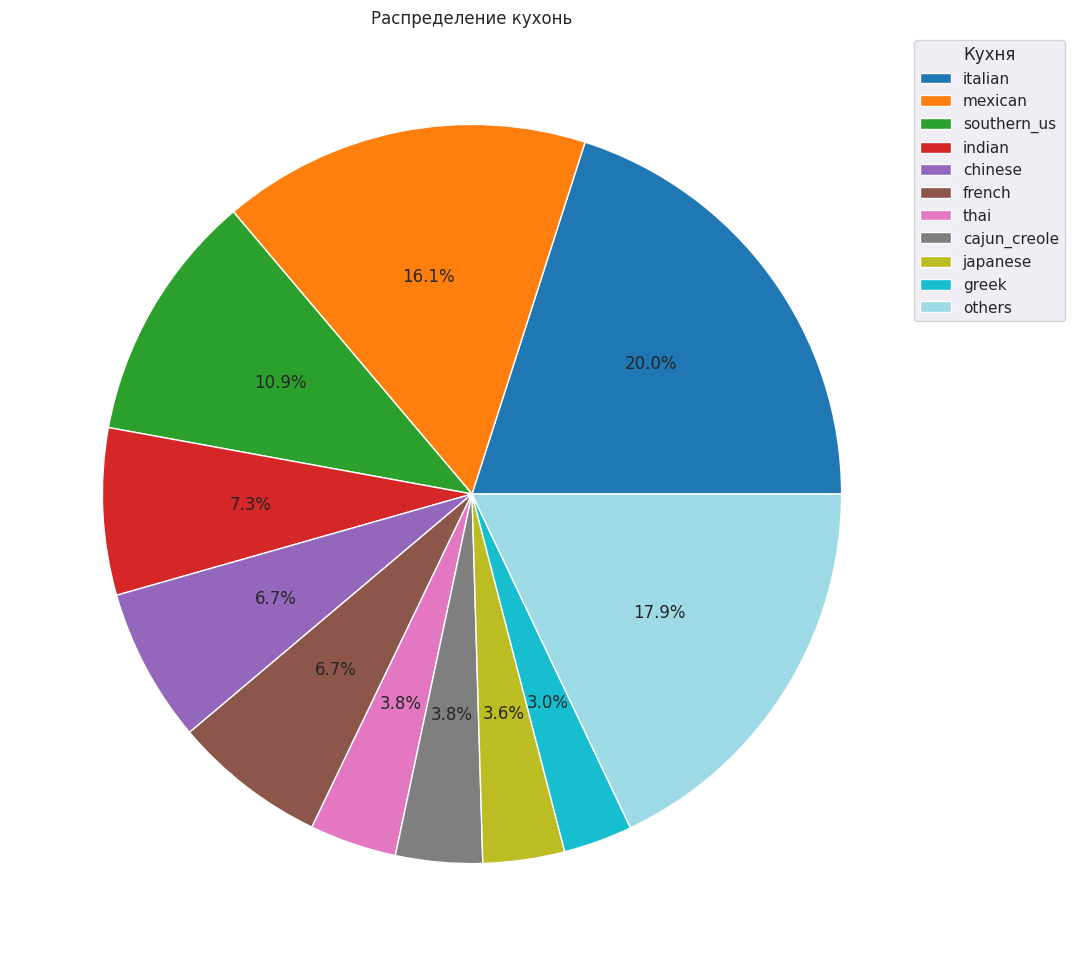

In [ ]:
labels = cuisine_plot.index

cuisine_plot.plot.pie(figsize=(12, 12),
                      title='Распределение кухонь',
                      autopct='%1.1f%%',
                      labels=None,
                      cmap='tab20')


plt.legend(title='Кухня', loc='upper right',
labels=labels, bbox_to_anchor=(1.15, 1))

plt.ylabel(None);

## Количество ингридиентов в кухнях

In [ ]:
all_ingredients = sum(cleaned_data['ingredients'], [])
unique_ingredients = set(all_ingredients)
total_unique_ingredients = len(unique_ingredients)

ingredients_per_cuisine = Counter()
for _, row in tqdm(cleaned_data.iterrows()):
    ingredients_per_cuisine[row['cuisine']] += len(row['ingredients'])

average_ingredients_per_cuisine = {cuisine: total / cuisine_distribution[cuisine]
                                   for cuisine, total in ingredients_per_cuisine.items()}

average_ingredients_per_cuisine = dict(sorted(average_ingredients_per_cuisine.items(), key=lambda item: item[1]))

38265it [00:02, 17568.58it/s]


In [ ]:
total_unique_ingredients, average_ingredients_per_cuisine

(6614,
 {'brazilian': 9.14645308924485,
  'irish': 9.238601823708207,
  'southern_us': 9.497852028639619,
  'british': 9.529936305732484,
  'japanese': 9.584491587417704,
  'french': 9.64733359283768,
  'italian': 9.772549530761209,
  'filipino': 9.865229110512129,
  'russian': 10.02928870292887,
  'greek': 10.107359307359307,
  'spanish': 10.25441329179647,
  'mexican': 10.449667693305235,
  'korean': 11.08695652173913,
  'jamaican': 11.627811860940696,
  'chinese': 11.695500387897596,
  'vietnamese': 11.894385026737968,
  'indian': 11.996418338108883,
  'thai': 12.078296703296703,
  'cajun_creole': 12.079255685733976,
  'moroccan': 12.358738501971091})

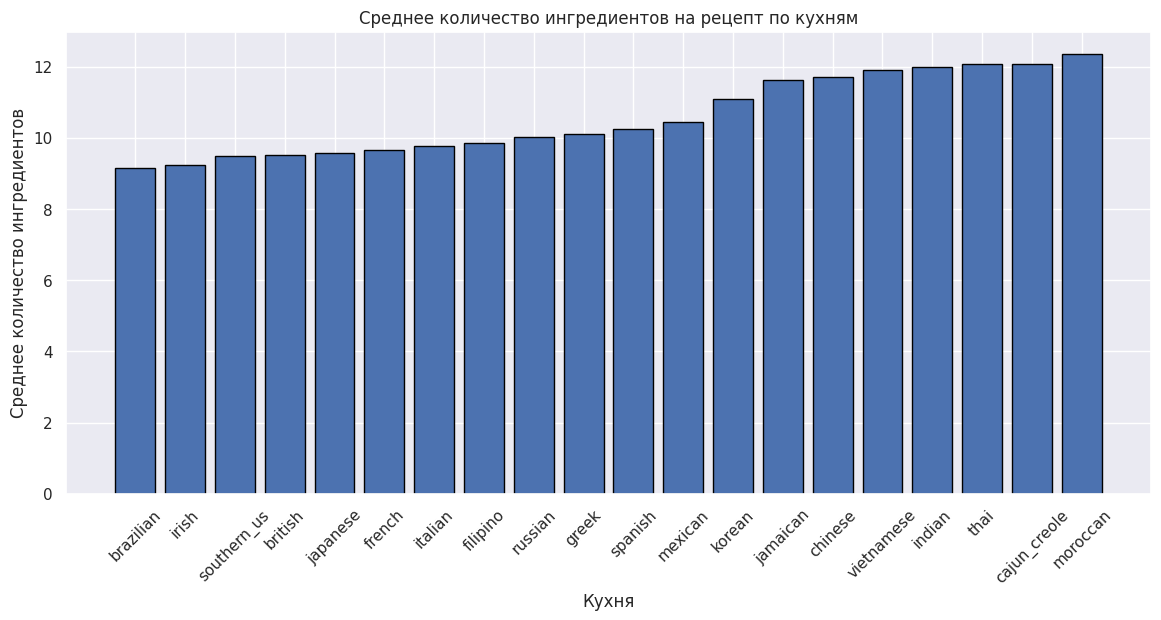

In [ ]:
plt.figure(figsize=(14, 6))
plt.bar(average_ingredients_per_cuisine.keys(),
        average_ingredients_per_cuisine.values(),
        edgecolor='black')
plt.title('Среднее количество ингредиентов на рецепт по кухням')
plt.xlabel('Кухня')
plt.ylabel('Среднее количество ингредиентов')
plt.xticks(rotation=45)
plt.show()

## Наиболее частые ингридиенты в кухнях

38265it [00:02, 17932.34it/s]


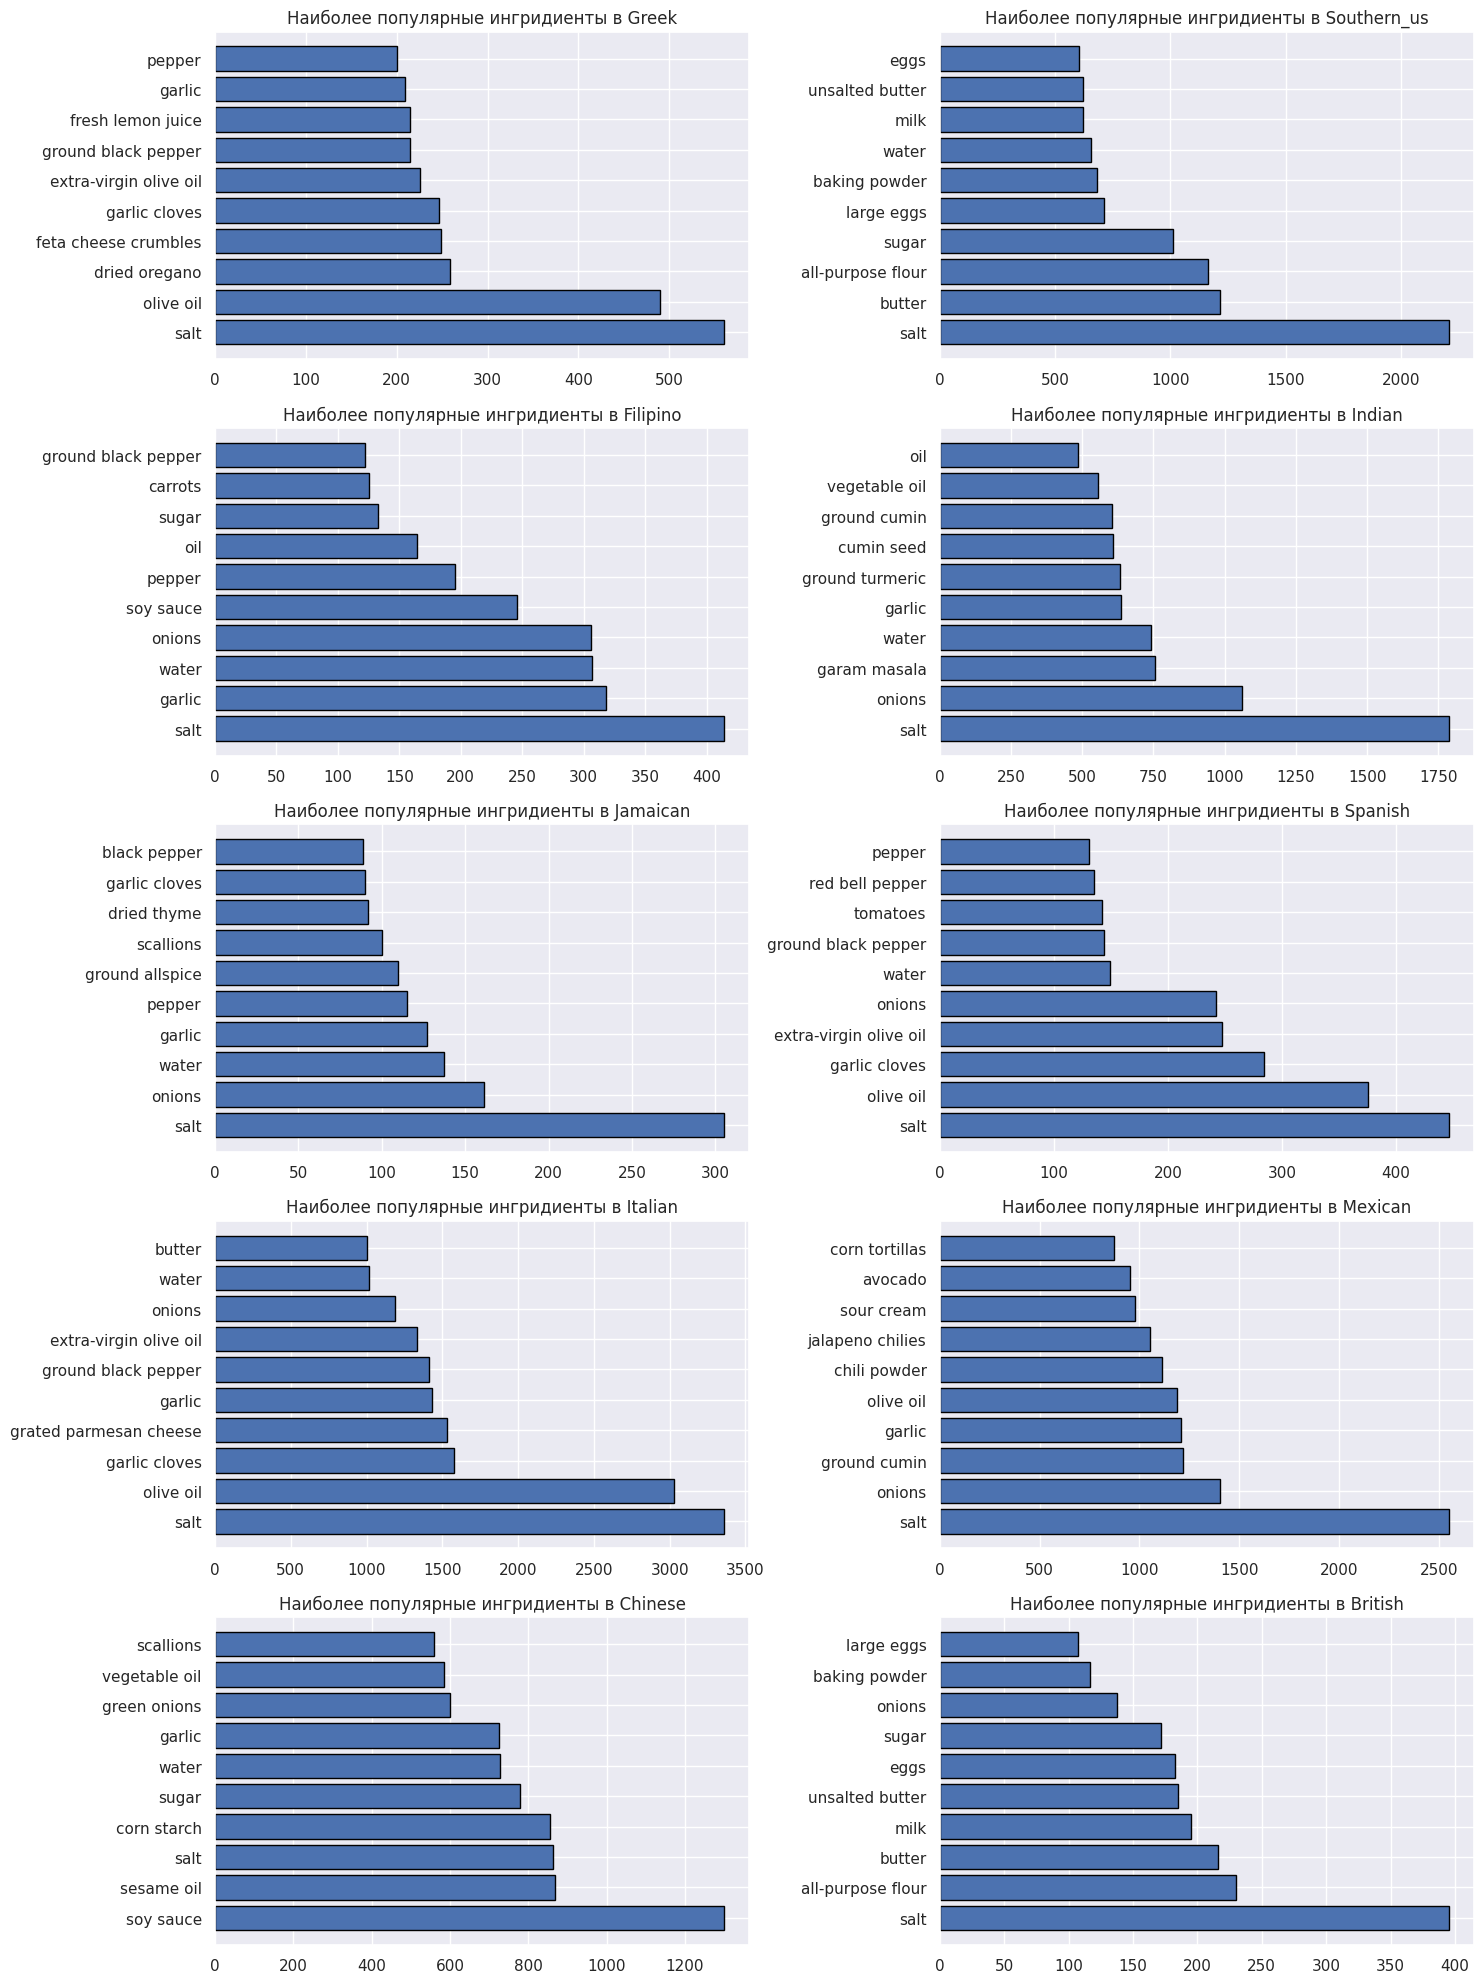

In [ ]:
ingredients_by_cuisine = {}
for _, row in tqdm(cleaned_data.iterrows()):
    cuisine = row['cuisine']
    ingredients = row['ingredients']
    if cuisine not in ingredients_by_cuisine:
        ingredients_by_cuisine[cuisine] = Counter()
    ingredients_by_cuisine[cuisine].update(ingredients)

fig, axes = plt.subplots(5, 2, figsize=(15, 20))
cuisines_to_display = list(ingredients_by_cuisine.keys())[:10]

for ax, cuisine in zip(axes.flatten(), cuisines_to_display):
    most_common_ingredients = ingredients_by_cuisine[cuisine].most_common(10)
    ingredients, counts = zip(*most_common_ingredients)
    ax.barh(ingredients, counts, edgecolor='black')
    ax.set_title(f'Наиболее популярные ингридиенты в {cuisine.capitalize()}')

plt.tight_layout()
plt.show()

## Количество ингридиентов в каждом рецепте

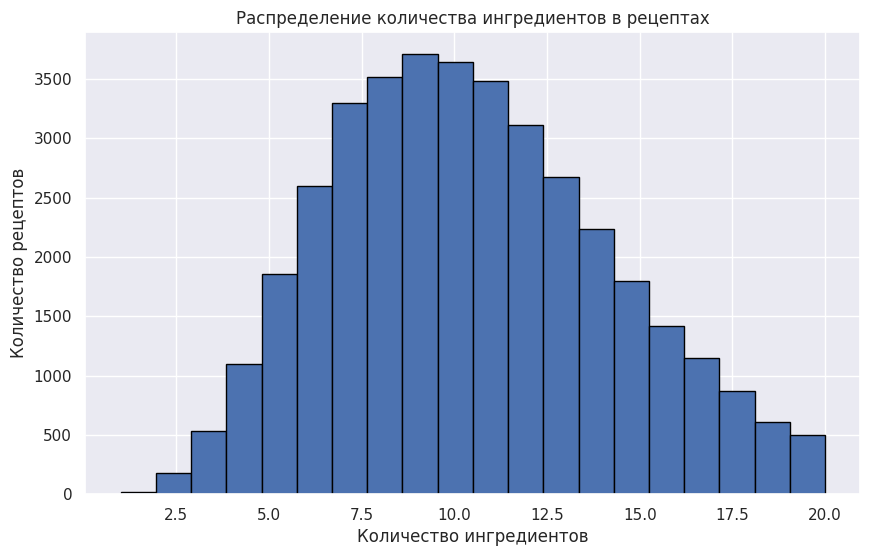

In [ ]:
count = cleaned_data['ingredients'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(count, bins=20, edgecolor='black')
plt.title('Распределение количества ингредиентов в рецептах')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Количество рецептов')
plt.show()

In [ ]:

count.describe()

count    38265.000000
mean        10.453731
std          3.921095
min          1.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         20.000000
Name: ingredients, dtype: float64

## Выводы

Изучив измененные графики, можно прийти к выводу, что распределения остались практически такими же.

Главное отличие - распределение ингридиентов. Теперь видно нормальное распределение.

# Выбор признаков и их кодирование

В качестве признаков для моделей используются ингредиенты.



* Использование CountVectorizer: CountVectorizer создаст вектор для каждого рецепта, где каждый ингредиент представлен уникальным числом, а его важность в рецепте измеряется частотой его встречаемости.



Stratify разбивает выборку на такое же соотношение, какое в исходном датафрейме

Таким образом, подсчитываются распределени доли присутствия кухонь, и с таким же соотношением они будут в тестовой и тренировочной выборке.

Это позволяет избавиться от момента, когда в тренировочной выборке не присутствуют данные, которые есть в тестовой.

In [ ]:
train_data, test_data = train_test_split(cleaned_data, test_size=0.3,
                                         random_state=42,
                                         stratify=cleaned_data['cuisine'])

train_size = train_data.shape[0]
test_size = test_data.shape[0]
train_size, test_size

(26785, 11480)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=False)

train_ingredients_combined = train_data['ingredients'].apply(lambda x: ' '.join(x))
test_ingredients_combined = test_data['ingredients'].apply(lambda x: ' '.join(x))

X_train = vectorizer.fit_transform(train_ingredients_combined)
X_test = vectorizer.transform(test_ingredients_combined)

y_train = train_data['cuisine']
y_test = test_data['cuisine']

# Анализ признаков

In [ ]:
X_train.shape, X_test.shape

((26785, 3151), (11480, 3151))

# Обучение моделей

In [ ]:
RES = {}

## Логистическая регрессия

In [ ]:
# Создание модели логистической регрессии
log_reg_model = LogisticRegression(max_iter=10000, random_state=42)

# Обучение модели
log_reg_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = log_reg_model.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test, y_pred)
RES['Linear regression'] = accuracy
accuracy

0.7712543554006969

# Случайный лес

In [ ]:
# Создание модели RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)

# Определение сетки гиперпараметров для поиска
param_grid = {
    'n_estimators': [100, 200, 300],  # Количество деревьев в лесу
    'max_depth': [10, 20, 30],        # Максимальная глубина дерева
    'min_samples_split': [2, 4, 6]    # Минимальное количество образцов, необходимых для разделения узла
}

# Создание GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(random_forest_model, param_grid,
                           cv=3, n_jobs=-1, scoring='accuracy')

# Обучение модели
grid_search.fit(X_train, y_train)

# Лучшие параметры и лучшая модель
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Предсказание на тестовом наборе
y_pred = best_model.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test, y_pred)
RES['Random forest'] = accuracy
accuracy

In [ ]:
random_forest = RandomForestClassifier(random_state=42)

# Обучение модели
random_forest.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = random_forest.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test, y_pred)
RES['Random forest'] = accuracy
accuracy

0.7468641114982578

## XgBoost

 Градиентный бустинг последовательно строит деревья решений таким образом, что каждое следующее дерево пытается исправить ошибки, сделанные предыдущими деревьями.

In [ ]:
# Создание и обучение LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Создание модели XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False,
                              eval_metric='mlogloss', random_state=42)

# Определение сетки гиперпараметров для поиска
param_grid = {
    'n_estimators': [100, 200, 300],     # Количество деревьев
    'max_depth': [3, 6, 9],              # Максимальная глубина дерева
    'learning_rate': [0.01, 0.1, 0.2]    # Скорость обучения
}

# Создание GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1,
                           scoring='accuracy')

# Обучение модели
grid_search.fit(X_train, y_train_encoded)

# Лучшие параметры и лучшая модель
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Предсказание на тестовом наборе
y_pred_xgb = best_model.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
RES['XGB'] = accuracy
accuracy

In [ ]:
# Создание модели XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False,
                              eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_encoded)



# Предсказание на тестовом наборе
y_pred_xgb = xgb_model.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
RES['XGB'] = accuracy
accuracy

0.785191637630662

## Нейронная сеть

In [ ]:
# Кодирование меток классов
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Преобразование разреженных матриц в плотные
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Определение количества классов
num_classes = len(np.unique(y_train_encoded))

In [ ]:
X_train_dense.shape, X_test_dense.shape

((26785, 3151), (11480, 3151))

In [ ]:
num_classes

20

In [ ]:
# Создание модели нейронной сети
model = Sequential()
model.add(Dense(512, activation='LeakyReLU', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Компиляция модели
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Создание коллбэков для ранней остановки и сохранения лучшей модели
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss',
                                   mode='min', save_best_only=True, verbose=1)

# Обучение модели
model.fit(X_train_dense, y_train_encoded, batch_size=128, epochs=25,
          validation_data=(X_test_dense, y_test_encoded),
          callbacks=[early_stopping, model_checkpoint])

# Загрузка лучшей модели
model.load_weights('best_model.h5')

# Оценка лучшей модели на тестовых данных
test_loss, test_acc = model.evaluate(X_test_dense, y_test_encoded)
print('Test Accuracy:', test_acc)

Epoch 1/25
203/210 [============================>.] - ETA: 0s - loss: 1.5486 - accuracy: 0.5541
Epoch 1: val_loss improved from inf to 0.95200, saving model to best_model.h5
210/210 [==============================] - 6s 13ms/step - loss: 1.5357 - accuracy: 0.5574 - val_loss: 0.9520 - val_accuracy: 0.7180
Epoch 2/25
203/210 [============================>.] - ETA: 0s - loss: 0.9444 - accuracy: 0.7230
Epoch 2: val_loss improved from 0.95200 to 0.80692, saving model to best_model.h5
210/210 [==============================] - 2s 8ms/step - loss: 0.9425 - accuracy: 0.7231 - val_loss: 0.8069 - val_accuracy: 0.7651
Epoch 3/25
209/210 [============================>.] - ETA: 0s - loss: 0.7970 - accuracy: 0.7648
Epoch 3: val_loss improved from 0.80692 to 0.78082, saving model to best_model.h5
210/210 [==============================] - 1s 6ms/step - loss: 0.7969 - accuracy: 0.7648 - val_loss: 0.7808 - val_accuracy: 0.7696
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 0.7163

In [ ]:
RES['Neural Network'] = test_acc

# Подсчет метрик

In [ ]:
RES

{'Linear regression': 0.7712543554006969,
 'Random forest': 0.7468641114982578,
 'XGB': 0.785191637630662,
 'Neural Network': 0.7816202044487}

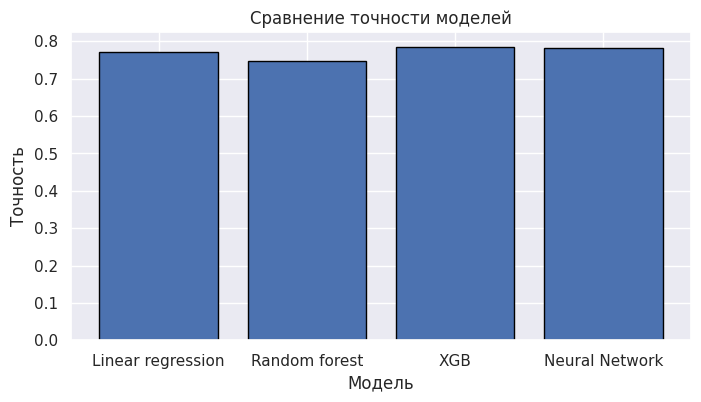

In [ ]:
# Данные для построения графика
models = list(RES.keys())
accuracy_values = list(RES.values())

# Создание столбцовой диаграммы
plt.figure(figsize=(8, 4))
plt.bar(models, accuracy_values, edgecolor='black')

# Добавление заголовка и меток
plt.title('Сравнение точности моделей')
plt.xlabel('Модель')
plt.ylabel('Точность')

# Отображение диаграммы
plt.show()

# Анализ результатов

В результате работы на представленном наборе данных были сравнены четыре различных моделей машинного обучения: линейной регрессии, случайного леса (Random forest), XGBoost (XGB) и нейронной сети (Neural Network).

Все модели показывают сопоставимые результаты точности, которые находятся в диапазоне от примерно 0.77 до 0.78.

Выводы:

* Близкие результаты: То, что все модели имеют близкие показатели точности, может свидетельствовать о том, что они достигли определённого "потолка" производительности на имеющихся данных.

Это может быть признаком того, что для всех моделей доступна одинаковая информация из данных и что они извлекают из этих данных максимум возможного.

* Сложность модели не гарантирует лучшую производительность: Более сложная модель, такая как нейронная сеть, не обязательно показывает лучшую точность по сравнению с более простыми моделями, такими как линейная регрессия или случайный лес.

Это может указывать на то, что сложность модели должна быть соответствующим образом настроена и адаптирована к конкретной задаче.
